In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_train = np.load('/kaggle/input/trainvalidationtest/Train Val Test/X_train.npy', allow_pickle=True)
y_train = np.load('/kaggle/input/trainvalidationtest/Train Val Test/y_train.npy', allow_pickle=True)
X_val = np.load('/kaggle/input/trainvalidationtest/Train Val Test/X_val.npy', allow_pickle=True)
y_val = np.load('/kaggle/input/trainvalidationtest/Train Val Test/y_val.npy', allow_pickle=True)
X_test = np.load('/kaggle/input/trainvalidationtest/Train Val Test/X_test.npy', allow_pickle=True)
y_test = np.load('/kaggle/input/trainvalidationtest/Train Val Test/y_test.npy', allow_pickle=True)

In [3]:
data_info = np.load('/kaggle/input/alllabels/labels.npy', allow_pickle=True)
file_paths = [item[0] for item in data_info]
labels = [item[1] for item in data_info]

In [4]:
label_to_index = {label: index for index, label in enumerate(np.unique(labels))}
y_train_encoded = np.array([label_to_index[label] for label in y_train])
y_val_encoded = np.array([label_to_index[label] for label in y_val])
y_test_encoded = np.array([label_to_index[label] for label in y_test])

num_classes = len(label_to_index)
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

In [5]:
X_train = pad_sequences(X_train, dtype='float32', padding='post', value=0.0)
X_val = pad_sequences(X_val, dtype='float32', padding='post', value=0.0)
X_test = pad_sequences(X_test, dtype='float32', padding='post', value=0.0)

In [6]:
X_train = np.vstack(X_train)
X_val = np.vstack(X_val)
X_test = np.vstack(X_test)

In [7]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_encoded_tensor = tf.convert_to_tensor(y_train_encoded, dtype=tf.float32)
y_val_encoded_tensor = tf.convert_to_tensor(y_val_encoded, dtype=tf.float32)
y_test_encoded_tensor = tf.convert_to_tensor(y_test_encoded, dtype=tf.float32)

In [8]:
signal_length = 2048

In [9]:
num_blocks = 5
filters = [32, 64, 128, 256] * num_blocks
kernel_sizes = [3, 5, 8, 16] * num_blocks
num_dense_layers = 1
dense_units = [64, 128, 256] * num_dense_layers

input_shape = (signal_length, 1)  

model = keras.Sequential()

model.add(layers.Input(shape=input_shape))  # Input layer
for i in range(num_blocks):
    model.add(layers.Conv1D(filters[i], kernel_sizes[i], activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters[i], kernel_sizes[i], activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters[i], kernel_sizes[i], activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())

for units in dense_units:
    model.add(layers.Dense(units, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2048, 32)          128       
                                                                 
 batch_normalization (BatchN  (None, 2048, 32)         128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 2048, 32)          3104      
                                                                 
 batch_normalization_1 (Batc  (None, 2048, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 2048, 32)          3104      
                                                                 
 batch_normalization_2 (Batc  (None, 2048, 32)         1

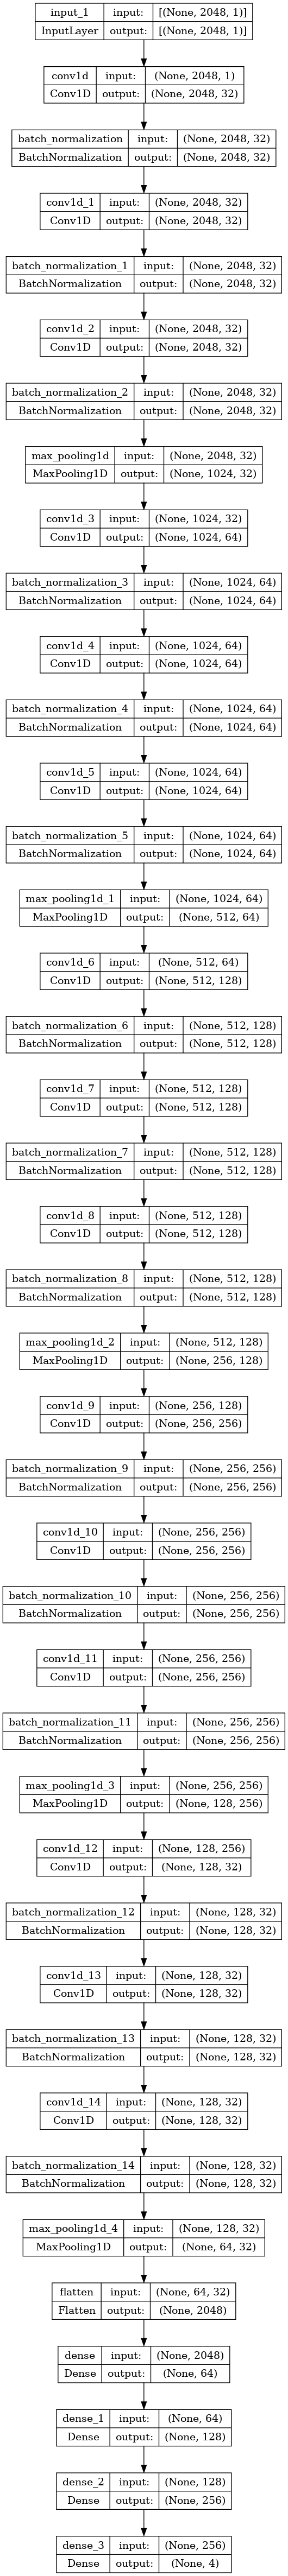

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
X_train_reshaped = X_train.reshape(-1, signal_length, 1)
X_val_reshaped = X_val.reshape(-1, signal_length, 1)
X_test_reshaped = X_test.reshape(-1, signal_length, 1)

In [12]:
mean = np.mean(X_train_reshaped)
std = np.std(X_train_reshaped)

X_train_normalized = (X_train_reshaped - mean) / std
X_val_normalized = (X_val_reshaped - mean) / std
X_test_normalized = (X_test_reshaped - mean) / std

In [13]:
epochs = 40
batch_size = 256
history = model.fit(X_train_normalized, y_train_encoded, validation_data=(X_val_normalized, y_val_encoded), epochs=epochs, batch_size=batch_size)

Epoch 1/40
547/547 [==============================] - 164s 261ms/step - loss: 0.0295 - accuracy: 0.9911 - val_loss: 7.1314 - val_accuracy: 0.4973
Epoch 2/40
547/547 [==============================] - 143s 262ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 3/40
547/547 [==============================] - 143s 262ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 5.3197 - val_accuracy: 0.7464
Epoch 4/40
547/547 [==============================] - 143s 262ms/step - loss: 0.0281 - accuracy: 0.9955 - val_loss: 39.1779 - val_accuracy: 0.2516
Epoch 5/40
547/547 [==============================] - 143s 262ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0069 - val_accuracy: 0.9980
Epoch 6/40
547/547 [==============================] - 143s 262ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0093 - val_accuracy: 0.9976
Epoch 7/40
547/547 [==============================] - 140s 256ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0016 

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")

print("Model and weights saved successfully.")

Model and weights saved successfully.


In [15]:
test_loss, test_acc = model.evaluate(X_test_normalized, y_test_encoded)
print(f'Test accuracy: {test_acc}')

938/938 [==============================] - 12s 13ms/step - loss: 3.3132e-05 - accuracy: 1.0000
Test accuracy: 1.0


In [16]:
predicted_probs = model.predict(X_test_normalized)
predicted_labels = np.argmax(predicted_probs, axis=1)

938/938 [==============================] - 10s 11ms/step


In [17]:
y_test_single_label = np.argmax(y_test_encoded, axis=1)

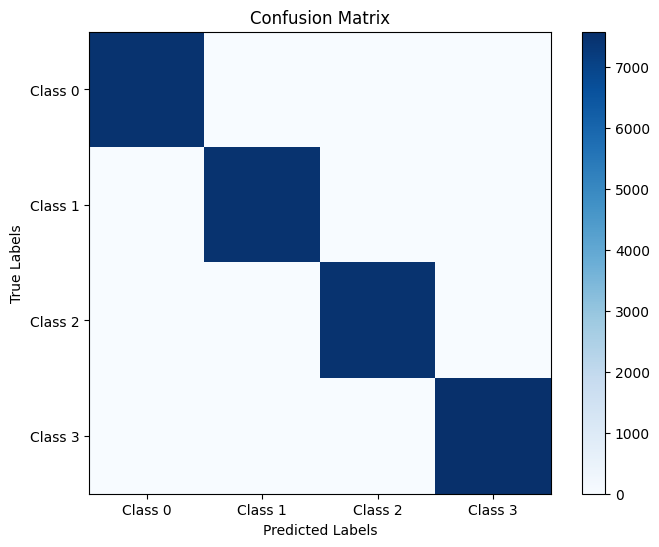

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7470
           1       1.00      1.00      1.00      7481
           2       1.00      1.00      1.00      7467
           3       1.00      1.00      1.00      7582

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [18]:
cm = confusion_matrix(y_test_single_label, predicted_labels)


plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm)), labels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.yticks(np.arange(len(cm)), labels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.show()

report = classification_report(y_test_single_label, predicted_labels)

print("Classification Report:\n", report)